In [1]:
import pandas as pd
from hs_gimme.db_facade.db_facade_factory import get_mongo_client_db
from hs_gimme.application_status_history_classifier.machine_learning_status_classifier import \
    get_machine_learning_status_classifier
from hs_gimme.account_settings_manager import get_account_settings
from collections import defaultdict, Counter
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [2]:
ACCOUNT = 'zagreb'

In [3]:
mongo = get_mongo_client_db('production', ACCOUNT)

2023-09-12T14:22:26.355387Z [info     ] Mongos instances selected      environment=local file_path=/Users/dima/hiredscore/gimme/hs_gimme/db_facade/connection_string_builder.py function_name=get_selected_mongos_instances hostname=Dima-Shulga-MacBook-Pro hosts=['applicativedb-prod-mongos-1.omcomcom.com', 'applicativedb-prod-mongos-0.omcomcom.com'] line_number=38 module=hs_gimme.db_facade.connection_string_builder pid=38517


In [4]:
account_settings = get_account_settings(ACCOUNT)
phases_order_mapping = {item['id']: order for order, item in
                        enumerate(account_settings.get('candidate_phases') or [])}
#phases_order_mapping = {'new': 0, 'review': 1, 'interview': 3, 'hiring_manager_review': 2, 'offer': 4}

phases_order_mapping

{'new': 0, 'assessment': 1, 'interview': 2, 'offer': 3, 'ready_for_hire': 4}

In [5]:
status_cls = get_machine_learning_status_classifier('production', ACCOUNT)

In [13]:
apps = list(mongo.application.find({'samurai_json.experience': {'$gt': []},
                                 'ats_application.status_info.status_history': {'$gt': []}, }).limit(5000))

In [103]:
paths_counts = Counter()
path_to_max_status = defaultdict(Counter)
for app in apps:
    max_status = status_cls.get_max_status(app)
    phases = status_cls.get_phases_reach_dates(app)
    path = str([p[0] for p in sorted(phases.items(), key=lambda x: x[1])])
    
    paths_counts[path] += 1
    path_to_max_status[path][int(max_status)] += 1
    

In [104]:
for p, v in paths_counts.most_common():
    print(p, v/5000, path_to_max_status[p])

['new', 'rejected'] 0.6504 Counter({-1: 3252})
['new'] 0.133 Counter({-1: 665})
['new', 'assessment', 'rejected'] 0.122 Counter({-1: 336, 1: 231, 2: 43})
['new', 'assessment', 'interview', 'rejected'] 0.0256 Counter({2: 128})
['new', 'assessment'] 0.0188 Counter({1: 75, -1: 13, 2: 6})
['new', 'obsolete'] 0.0112 Counter({-1: 56})
['new', 'offer', 'ready_for_hire'] 0.0098 Counter({3: 49})
['new', 'assessment', 'interview', 'offer', 'ready_for_hire'] 0.008 Counter({3: 40})
['new', 'assessment', 'interview'] 0.0038 Counter({2: 19})
['new', 'obsolete', 'offer', 'ready_for_hire'] 0.0034 Counter({3: 17})
['new', 'obsolete', 'rejected'] 0.0028 Counter({-1: 14})
['new', 'offer', 'rejected'] 0.0016 Counter({3: 8})
['new', 'assessment', 'interview', 'offer', 'rejected'] 0.0014 Counter({3: 7})
['new', 'obsolete', 'interview', 'offer', 'ready_for_hire'] 0.0008 Counter({3: 4})
['new', 'assessment', 'rejected', 'interview'] 0.0006 Counter({2: 3})
['new', 'rejected', 'assessment'] 0.0006 Counter({1: 2

In [14]:
def get_max_phase(app):
    phases = set(status_cls.get_phases_reach_dates(app).keys()) - {'rejected'}
    if phases:
        return max(phases, key=lambda p: phases_order_mapping.get(p, -1))
    else:
        return 'NONE'

In [44]:
STATUS = 'JOB_APPLICATION_DEFAULT_DEFINITION_STEP_A_ASSESSMENT_ACTION'

In [69]:
data = []
dirs = defaultdict(Counter)

edges = Counter()
G = nx.DiGraph()
statuses_G = nx.DiGraph()
status_edges = Counter()
path
for app in apps:
    max_status = status_cls.get_max_status(app)
    path
    
    max_phase = get_max_phase(app)
    
    phases = status_cls.get_phases_reach_dates(app)
    
    statuses = sorted(app['ats_application']['status_info']['status_history'], key=lambda s: s['date'])
    
    prev = 'START'
    for i, s in enumerate(statuses): 
        status_edges[(prev, s['step_name'])] += 1
        statuses_G.add_edge(prev, s['step_name'])
        prev = s['step_name']
    
    statuses_G.add_edge(prev, 'END')
    
    prev = 'START'
    for i, (p, d) in enumerate(sorted(phases.items(), key=lambda x: x[1])):
        dirs[p][i] += 1
        
        edges[(prev, p)] += 1
        G.add_edge(prev, p)
        prev = p
        
    G.add_edge(prev, 'END')
    edges[(prev, 'END')] += 1
        
    data.append({
        'app_id': app['_id'],
        'app': app,
        'max_status': max_status,
        'max_phase': max_phase,
        'phases': phases })
    
df = pd.DataFrame(data)

In [70]:
phases

{'new': datetime.datetime(2022, 1, 20, 17, 51, 3, 215000),
 'assessment': datetime.datetime(2022, 1, 21, 16, 54, 31, 43000),
 'rejected': datetime.datetime(2022, 2, 10, 23, 32, 47, 865000)}

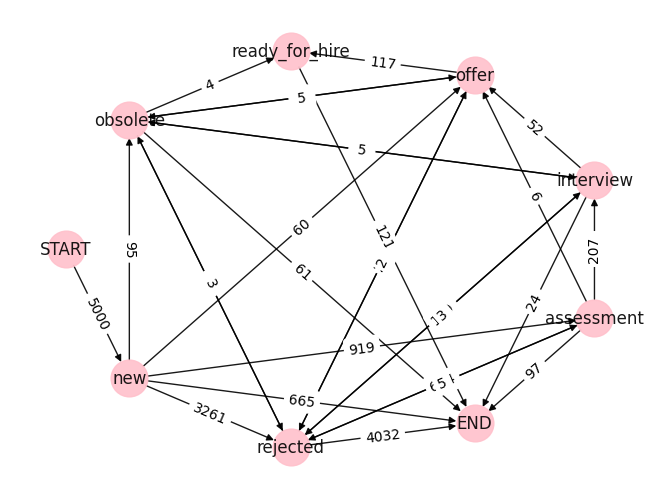

In [71]:
G = nx.DiGraph()
G.add_edges_from(edges)
pos = nx.shell_layout(G)
plt.figure()
nx.draw(
    G, pos, edge_color='black', width=1, linewidths=1,
    node_size=700, node_color='pink', alpha=0.9,
    labels={node: node for node in G.nodes()}
)
nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels=edges,
    #font_color='green'
)
plt.draw()  # pyplot draw()

In [78]:
paths = Counter()

for p in nx.all_simple_paths(G, 'START', 'END'):
    vs = []
    for edge in zip(p, p[1:]):
        vs.append(edges[edge])
        
        
    paths[str(p)] = min(vs)

In [81]:
for p, v in paths.most_common():
    print(p, v/5000)

['START', 'new', 'rejected', 'END'] 0.6522
['START', 'new', 'END'] 0.133
['START', 'new', 'assessment', 'rejected', 'END'] 0.1228
['START', 'new', 'assessment', 'interview', 'rejected', 'END'] 0.0258
['START', 'new', 'assessment', 'END'] 0.0194
['START', 'new', 'obsolete', 'END'] 0.0122
['START', 'new', 'offer', 'ready_for_hire', 'END'] 0.012
['START', 'new', 'assessment', 'interview', 'offer', 'ready_for_hire', 'END'] 0.0104
['START', 'new', 'obsolete', 'offer', 'ready_for_hire', 'END'] 0.005
['START', 'new', 'assessment', 'interview', 'END'] 0.0048
['START', 'new', 'assessment', 'interview', 'offer', 'rejected', 'END'] 0.0046
['START', 'new', 'offer', 'rejected', 'END'] 0.0046
['START', 'new', 'obsolete', 'offer', 'rejected', 'END'] 0.0046
['START', 'new', 'obsolete', 'rejected', 'END'] 0.0036
['START', 'new', 'assessment', 'interview', 'obsolete', 'offer', 'ready_for_hire', 'END'] 0.002
['START', 'new', 'assessment', 'interview', 'obsolete', 'offer', 'rejected', 'END'] 0.002
['START

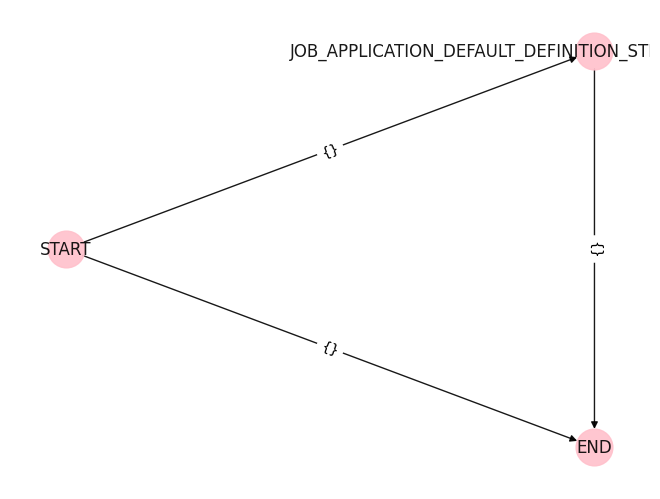

In [51]:
G = nx.DiGraph()
G.add_edges_from(edges)
pos = nx.shell_layout(statuses_G)
plt.figure()
nx.draw(
    statuses_G, pos, edge_color='black', width=1, linewidths=1,
    node_size=700, node_color='pink', alpha=0.9,
    labels={node: node for node in statuses_G.nodes()}
)
nx.draw_networkx_edge_labels(
    statuses_G, pos,
    edge_labels=statuses_G.edges,
    #font_color='green'
)
plt.draw() 

In [17]:
df['max_phase'].value_counts(normalize=True)

new               0.7980
assessment        0.1414
interview         0.0316
ready_for_hire    0.0242
offer             0.0048
Name: max_phase, dtype: float64

In [18]:
df['max_phase'].value_counts(normalize=True)

new               0.7980
assessment        0.1414
interview         0.0316
ready_for_hire    0.0242
offer             0.0048
Name: max_phase, dtype: float64

In [19]:
df[(df['max_status'] == 2) & (df['max_phase'] == 'review')]['app'].iloc[0]['ats_application']['status_info']

IndexError: single positional indexer is out-of-bounds

In [ ]:
wm = {}
for k, cnt in dirs.items():
    wm[k] = sum([p*v for p, v in cnt.items()])/sum([v for p, v in cnt.items()])

In [ ]:
for k, cnt in sorted(dirs.items(), key=lambda x: wm[x[0]]):
    print('='*3, k, '='*3, wm[k])
    print(cnt.most_common())
    print()
    

In [ ]:
{'new': 0, 'review': 1, 'interview': 3, 'hiring_manager_review': 2, 'offer': 4}

In [ ]:
def get_steps(app):
    if app:
        return [s.get('step_name') for s in app['ats_application']['status_info']['status_history']]

In [ ]:
df['steps'] = df['app'].apply(get_steps)

In [ ]:
sdf = df[df['max_phase'].isin({'obsolete', 'review'})]

In [ ]:
exp = sdf.explode('steps')

In [ ]:
exp.groupby(['steps']).size()